## Job Title Generalization ##

In [4]:
# import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import random
import openai
from dotenv import load_dotenv
import os
import json
import fasttext
from sklearn.model_selection import train_test_split
import re

In [5]:

df=pd.read_csv('data_set.csv')

## Data Cleaning ##

In [3]:
df.head(10)

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
5,00000339390,"Interior Stress Analysis Engineer - Career, Ex...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
6,00000340676,Flight Controls Laws and Autoflight Engineer (...,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
7,00000359847,Lead RF/Digital Hardware Subsystems Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
8,00000361859,Senior Integrated Circuit Layout Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
9,00000362125,Senior Interiors Design Engineer - Level 4,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."


In [4]:
df['JobDescription'][10]

"**Job Description**\\n\\nAt Boeing, we innovate and collaborate to make the world a better place. From the seabed to outer space, you can contribute to work that matters with a company where diversity, equity and inclusion are shared values. We're committed to fostering an environment for every teammate that's welcoming, respectful and inclusive, with great opportunity for professional growth. Find your future with us.\\n\\nThe Boeing Company has an exciting opportunity for  **Veterans- Associate/ Experienced/ Senior**   **Multi-skill Engineer (Levels 2-4)**  to join current and emerging programs located in  **Berkeley, MO.**  This position will focus on supporting the Boeing Defense, Space & Security (BDS) business organization.\\n\\nEngineers are the people who create, design and process the avionics in Boeing Defense Systems (BDS) products that we use in the modern world. Boeing needs experienced veterans who have worked on our product lines throughout their military tenure. We wan

**Removing HTML Tags**

In [6]:
# Function to clean the text by removing special characters
# def clean_text(text):
#     if isinstance(text, str):
#         text = text.replace("\\n", "\n")  # Replace "\\n" with actual new lines
#         text = text.replace("\n", "")
#         text = text.replace("+", "")
#         text = text.replace("**", "")     # Remove "**"
#     return text

# # Apply the function to the JobDescription column
# df['JobDescription'] = df['JobDescription'].apply(clean_text)

# Function to remove HTML tags
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Apply the function to the JobDescription column
df['JobDescription'] = df['JobDescription'].apply(clean_html)

/tmp/ipykernel_4019/2700934483.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [5]:
df['JobDescription'][10]

"**Job Description**\\n\\nAt Boeing, we innovate and collaborate to make the world a better place. From the seabed to outer space, you can contribute to work that matters with a company where diversity, equity and inclusion are shared values. We're committed to fostering an environment for every teammate that's welcoming, respectful and inclusive, with great opportunity for professional growth. Find your future with us.\\n\\nThe Boeing Company has an exciting opportunity for  **Veterans- Associate/ Experienced/ Senior**   **Multi-skill Engineer (Levels 2-4)**  to join current and emerging programs located in  **Berkeley, MO.**  This position will focus on supporting the Boeing Defense, Space & Security (BDS) business organization.\\n\\nEngineers are the people who create, design and process the avionics in Boeing Defense Systems (BDS) products that we use in the modern world. Boeing needs experienced veterans who have worked on our product lines throughout their military tenure. We wan

In [7]:
nan_count = np.sum(df.isnull(), axis=0)
nan_count

RequisitionID     1
OrigJobTitle      0
JobTitle          0
JobDescription    0
dtype: int64

## Job Description Sentence Classifier ##

In [8]:
random_sample = df['JobDescription'].sample(n=500, random_state=42)
random_sample.head()

9666     SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...
2724     Requisition Number: 15838 \n\nRequired Travel:...
19006    **Secure our Nation, Ignite your Future**\n\n*...
15304    Description:\n\nWe are looking for an Instrume...
14411    RH2 is currently seeking an entry-level Staff ...
Name: JobDescription, dtype: object

***Setting OpenAI API key***

In [22]:
# Set up your OpenAI API key
openai.api_key = "API_KEY"

In [23]:
# Set up your OpenAI API key
#load_dotenv() # loads the .env file
#api_key = os.getenv('API_KEY')

In [24]:
# Check if the API key is loaded correctly
#if api_key is None:
    #print("API key not found!")
#else:
    #print("API key loaded successfully.")


In [25]:

def call_openai_api(job_posting): 
    prompt = f"""
    Break up the following job description into the following categories: Marketing, Description, Requirements, Legal.
    For each category, return an array containing the sentences from the job posting corresponding to the category. Return this in JSON formatting

    Job Posting:
    "{job_posting}"

    The format should be as follows:

    **Marketing:** [Any sentence that promotes the job or company]
    **Description:** [Any sentence that explains the job role, company, or purpose of the role]
    **Requirements:** [Any sentence that outlines qualifications or skills needed for the role]
    **Legal:** [Any sentence that includes legal or compliance information such as equal opportunity statements, privacy, or legal disclaimers]
    """
    try:
        # Directly use openai.ChatCompletion.create() without defining a client
        chat_completion = openai.ChatCompletion.create(
            model="gpt-4o-mini",  # Ensure the correct model is being used
            messages=[{
                "role": "user", 
                "content": "follow the format and DON't other weird delimiters." + prompt
            }]
        )

        # Get the content from the response
        parsed_response = chat_completion['choices'][0]['message']['content']

        '''parsed_response = json.loads(response_content)
        
        file_path = "job_posting_categories.json"

        # Check if the file exists
        if os.path.exists(file_path):
            # If the file exists, read its content
            with open(file_path, "r") as json_file:
                try:
                    existing_data = json.load(json_file)  # Load existing content
                except json.JSONDecodeError:
                    existing_data = []  # If file is empty or invalid JSON, start with an empty list
        else:
            existing_data = []

        # Append the new data to the existing list
        existing_data.append(parsed_response)

        # Write the updated list back to the file
        with open(file_path, "w") as json_file:
            json.dump(existing_data, json_file, indent=4)'''


        return parsed_response
        '''response_dict = chat_completion.choices[0].message.content 

        testing_df['Categorized_Posting']

        save_to_json(response_dict, "output.json")

        return response_dict'''
    
    except Exception as e: 
        return f"Error: {str(e)}"

In [26]:
 #Apply the `call_openai_api` function to each job description
random_sample_categorized = random_sample.apply(call_openai_api)

In [27]:
# Option 1: Store the results in a DataFrame
result_df = pd.DataFrame({
    'JobDescription': random_sample,
    'Categorized_Posting': random_sample_categorized
})

**Training Dataset**

In [28]:
result_df.to_csv('output_file.csv', index=False)

In [29]:
print(result_df['Categorized_Posting'][9666])

```json
{
  "Marketing": [
    "Want to be part of the team? Apply today! We look forward to meeting you.",
    "We serve the heroes who protect our freedom.",
    "Recognized as one of America's top large company employers, we are a values and ethics driven organization that puts people's safety and well-being first.",
    "Working at HII is more than a job - it's an opportunity to build a future."
  ],
  "Description": [
    "With more than 25,000 employees - including third-, fourth- and even fifth-generation shipbuilders - HII's Newport News Shipbuilding (NNS) division is the largest industrial employer in Virginia.",
    "Our diverse and innovative team of professionals ranges from skilled trades to project managers, engineers and software developers to solution architects, technical subject matter experts, and system users.",
    "Anchored in our rich, 135-year history, we collaborate together at the forefront of technology, manufacturing, and integration of the most powerful and

In [31]:
pip install fasttext

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 KB 943.2 kB/s eta 0:00:001m970.3 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296198 sha256=94e7bd5c47c7ee2ecfa7fedce38fdf2f93f734491ca8c00d1a735760c7514f68
  Stored in directory: /home/iman/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
Note: you may need to restart the kernel to use updated packages.


**Prepare the Data for FastText**

**Train the FastText Classifier**

In [7]:
data = pd.read_csv('output_file.csv')

# Function to extract and format the data for FastText
def extract_fasttext_format(row): 
    try: 
        # Parse the JSON from the Categorized_Posting column 
        categorized_data = json.loads(row['Categorized_Posting'].replace("```json", "").replace("```", "")) 
        fasttext_lines = [] 
        # Loop through each category and its sentences 
        for category, sentences in categorized_data.items(): 
            for sentence in sentences: 
                if category == "Description":
                    fasttext_line = f"__label__Description {sentence.strip()}"
                else:
                    fasttext_line = f"__label__Not___label__Description {sentence.strip()}" 
                fasttext_lines.append(fasttext_line) 
        return fasttext_lines 
    except json.JSONDecodeError: 
        return [] 
# Apply the function to each row and collect all the FastText-formatted lines
fasttext_data = data.apply(extract_fasttext_format, axis=1)

# Flatten the list of lists into one list containing all sentences with their labels
all_sentences = [sentence for sublist in fasttext_data for sentence in sublist]

# Step 2: Split the data into training and validation sets (80% train, 20% validation)
train_data, valid_data = train_test_split(all_sentences, test_size=0.2, random_state=42)

# Save the training and validation data to separate files for FastText training
with open('fasttext_train.txt', 'w') as f:
    for sentence in train_data:
        f.write(sentence + '\n')

with open('fasttext_valid.txt', 'w') as f:
    for sentence in valid_data:
        f.write(sentence + '\n')



In [8]:
# Step 3: Train the FastText model on all labeled data (not just 'Description')
model = fasttext.train_supervised(input="fasttext_train.txt", epoch=25, lr=1.0, wordNgrams=2)

# Step 4: Evaluate on the validation data
result = model.test("fasttext_valid.txt")
print(f"Validation Results: Precision: {result[1]}, Recall: {result[2]}, Accuracy: {result[0]/len(valid_data)}")

# Optional: Save the trained model
model.save_model("job_description_classifier.bin")

Read 0M words
Number of words:  19320
Number of labels: 2
Progress: 100.0% words/sec/thread:  539472 lr:  0.000000 avg.loss:  0.043638 ETA:   0h 0m 0s


Validation Results: Precision: 0.9131274131274131, Recall: 0.9131274131274131, Accuracy: 1.0


**Mihili's Extracting Description Function**

In [9]:
def extract_descriptions(job_description):
    sentences = job_description.split('. ') 
    description_sentences = []
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    labels = model.predict(sentences)[0]  # Get the labels from the predictions

    for sentence, label in zip(sentences, labels):
        if label[0] == '__label__Description':  # Check if the label is 'Description'
            description_sentences.append(sentence.replace('\\n', '\n'))
    
    return description_sentences

In [10]:
df_sentences = pd.DataFrame()
df_sentences['ExtractedDescriptions'] = df['JobDescription'].apply(extract_descriptions)

In [11]:
df_sentences.to_csv('extracted_sent.csv', index=False)
df_sentences['ExtractedDescriptions'][2]


['Find your future with us.\n\nJob Description\n\n**Boeing Commercial Airplanes**  is hiring a  **Propulsion Engineer (Associate, Mid-level and Experience)**  to support  **Propulsion System Engineering**  in the  **Puget Sound**  area of  **Washington** .\n\n**Boeing Commercial Airplanes (BCA)**  engineering designs, builds, certifies, delivers, and maintains products and services that provide superior safety, quality, and value to our airline customers',
 'We are dedicated to safety, quality, innovation, and technical excellence in order to make our products, customers, and Boeing successful.\n\nOur Propulsion Organization is a world-class team of over 1000 engineers supporting our customers across the product life-cycle from product development to certification to fleet support',
 'Our core organization supports all programs and ensures functional excellence, while our integrated Product Teams are co-located and support specific airplane programs']

In [12]:
df_sentences = pd.read_csv('extracted_sent.csv')
df['DescriptionSentences'] = df_sentences['ExtractedDescriptions']


In [13]:
print(df['JobDescription'][2000])
print('\n')
print(df['DescriptionSentences'][2000])

Chief Building Engineer Supervisor - (Healthcare)\n\nJob ID\n\n133617\n\nPosted\n\n17-Aug-2023\n\nService line\n\nGWS Segment\n\nRole type\n\nFull-time\n\nAreas of Interest\n\nBuilding Management, Engineering/Maintenance\n\nLocation(s)\n\nNewark - Delaware - United States of America, Wilmington - Delaware - United States of America\n\nCBRE Global Workplace Solutions (GWS) works with clients to make real estate a significant contributor to organizational productivity and performance. Our account management model is at the heart of our client-centric approach to delivering integrated real estate solutions. Each client is entrusted with a dedicated leader and is supported by regional and global resources, demonstrating the industry's most robust platform. CBRE GWS delivers consistent, measurably superior outcomes for our clients at every stage of the lifecycle, and across industries and geographies.\n\nThis is a strategic position serving one of our most prestigious life sciences partners

**Cleaning up Description Sentences before Vectorizing**

**Vectorize All Job Descriptions**

In [16]:
df.head(5)

,RequisitionID,OrigJobTitle,JobTitle,JobDescription,DescriptionSentences
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...,['Licensed Stationary Engineer \n\n Froedtert ...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...,['**Boeing Defense and Space Systems** is gro...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ...",['Find your future with us.\n\nJob Description...
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ...","[""We are engineers and technicians, skilled sc..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ...",['Find your future with us.\n\nBoeing Defense ...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert job descriptions into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=300)  # Adjust max_features as needed
job_description_vectors = vectorizer.fit_transform(df['JobDescription'])

In [15]:
from sklearn.cluster import KMeans

# Choose the number of clusters based on the variety of job titles or description types
num_clusters = 10  # Adjust this to suit your data better
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(job_description_vectors)

# Add the cluster labels to your DataFrame
df['Cluster'] = kmeans.labels_

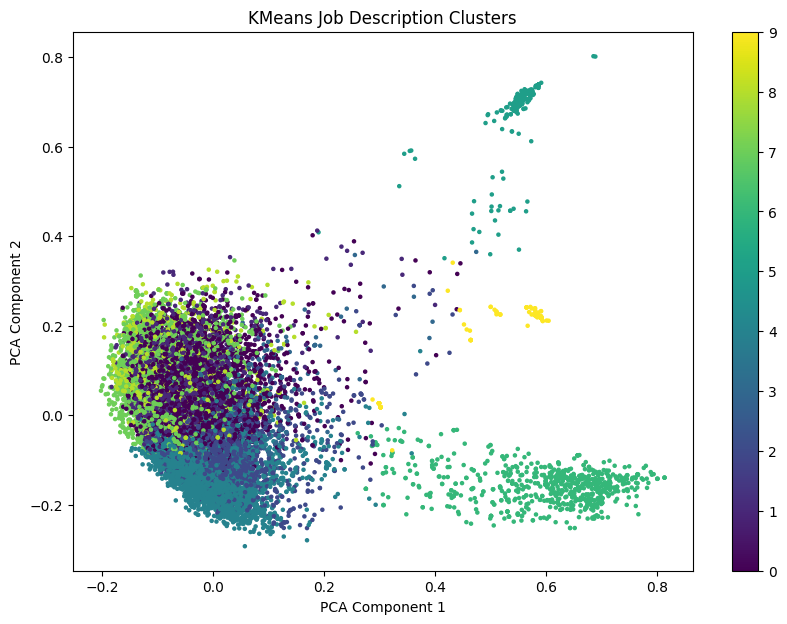

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(job_description_vectors)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['Cluster'], cmap='viridis', s=5)
plt.colorbar()
plt.title("KMeans Job Description Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [17]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 18.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.4 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 33.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Loop through each cluster
for cluster_num in range(num_clusters):
    # Filter job descriptions belonging to the current cluster
    cluster_descriptions = df[df['Cluster'] == cluster_num]['JobDescription'].tolist()
    
    # Use CountVectorizer to find frequent terms
    vectorizer = CountVectorizer(max_features=5, stop_words='english')
    vectorizer.fit(cluster_descriptions)
    
    # Get the top terms for this cluster
    top_words = vectorizer.get_feature_names_out()
    print(f"Cluster {cluster_num}: Suggested Job Title Keywords - {top_words}")

Cluster 0: Suggested Job Title Keywords - ['engineering' 'experience' 'systems' 'technical' 'work']
Cluster 1: Suggested Job Title Keywords - ['engineering' 'experience' 'manufacturing' 'process' 'work']
Cluster 2: Suggested Job Title Keywords - ['engineering' 'experience' 'position' 'requirements' 'work']
Cluster 3: Suggested Job Title Keywords - ['business' 'cloud' 'data' 'experience' 'solutions']
Cluster 4: Suggested Job Title Keywords - ['design' 'engineering' 'experience' 'team' 'work']
Cluster 5: Suggested Job Title Keywords - ['la' 'maintenance' 'mantenimiento' 'repair' 'reparacin']
Cluster 6: Suggested Job Title Keywords - ['apple' 'applicants' 'experience' 'napple' 'new']
Cluster 7: Suggested Job Title Keywords - ['design' 'engineering' 'experience' 'project' 'work']
Cluster 8: Suggested Job Title Keywords - ['equipment' 'maintenance' 'required' 'systems' 'work']
Cluster 9: Suggested Job Title Keywords - ['com' 'https' 'njob' 'usa' 'www']
